# **Time Series Prediction using Python**

### Understand the business scenario and problem

Our fictional vet clinic ( VetGroup ) wants to understand if there is a reliable way to predict the inflow of pacients coming through their doors.
The predictions of the model could have an important impact in the company by anticipating high and low peaks of treatment. Also it can help to plan staff leaves, stock for meds and accomodation necessary for the animals.

The aim of this analysis is to try to find the model that predicts most accurately the future number of treatments.
To achieve this goal I will explore three different models:
- Exponential smoothing
- Sarimax
- XG Boosting for time series regression



### Familiarize yourself with the vet dataset 

In this [dataset](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv), there are 7812 rows, 5 columns, and these variables: 

Variable  |Description |
-----|-----| 
Date|Date of treatment|
Company|The name of the company|
Country|Country where the clinic is situated|
Pacient Category|Kind of animal treated|
Treatments|Number of treatments performed|
Avg treatment time in minutes|Average time to treat one animal|

In [7]:
# Import packages

# For data manipulation
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data modeling
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from scipy.fft import fft

# For metrics and useful functions
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer

import pickle

# Load the data

url = "https://raw.githubusercontent.com/CSC1992/Time-Series-Forecasting/main/dummy_vet_data.csv"
df = pd.read_csv(url,
                 delimiter=",", 
                 parse_dates= ['Date'],
                 dayfirst=True
                 )

# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7812 entries, 0 to 7811
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           7812 non-null   datetime64[ns]
 1   Company                        7812 non-null   object        
 2   Country                        7812 non-null   object        
 3   Pacient_Category               7812 non-null   object        
 4   Treatments                     7812 non-null   int64         
 5   Avg treatment time in minutes  7812 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 366.3+ KB


### Exploratory Data Analysis

We do not have any missing values in the data which is a good start. 
We still need to check several parameters before modeling:

1- Check for duplicate values to ensure the data is clean

2- Understand the frequency of the dates and determine if we need to keep all the columns for our analysis

3- To predict the number of treatments as a whole, first we need to group the treatments by date and remove the other columns

4- Understand the distribution and seasonality of the data

5- Check for outliers and decide to keep them or remove them

In [29]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

In [30]:
# create the column day with name
df['day'] = df['Date'].dt.day_name()

# unique values of day
df.value_counts('day')

# only business day are present in the dataframe

day
Monday       1570
Wednesday    1566
Tuesday      1563
Thursday     1560
Friday       1553
Name: count, dtype: int64

In [31]:
# Isolate the variables for modeling
df1 = df[['Date','Treatments']]

# Group by date
ts = df1.groupby('Date').sum()
ts.reset_index(inplace=True)

# Define date as index and frequency as business days
ts = ts.set_index('Date').asfreq('B').ffill()

<Figure size 3000x2000 with 0 Axes>

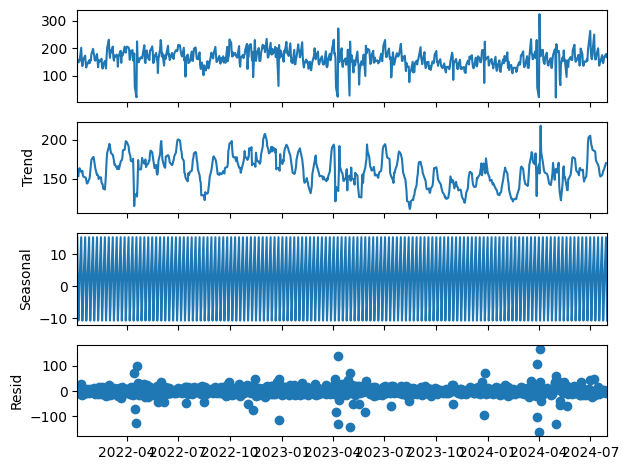

In [32]:
# Plot to analyse the trend, sazonality and distribution of data
result = seasonal_decompose(ts)
plt.figure(figsize=(30, 20))
result.plot();
plt.show();

### Trend, seasonality and distribution of data

The distribution of the data is quite irregular.

The General trend pattern resembles a wave that moves along the months

It appears to exist a seasonality throughout the days of the week indicated by the frequent cycles represented in the graph.

Let's test these assumptions.

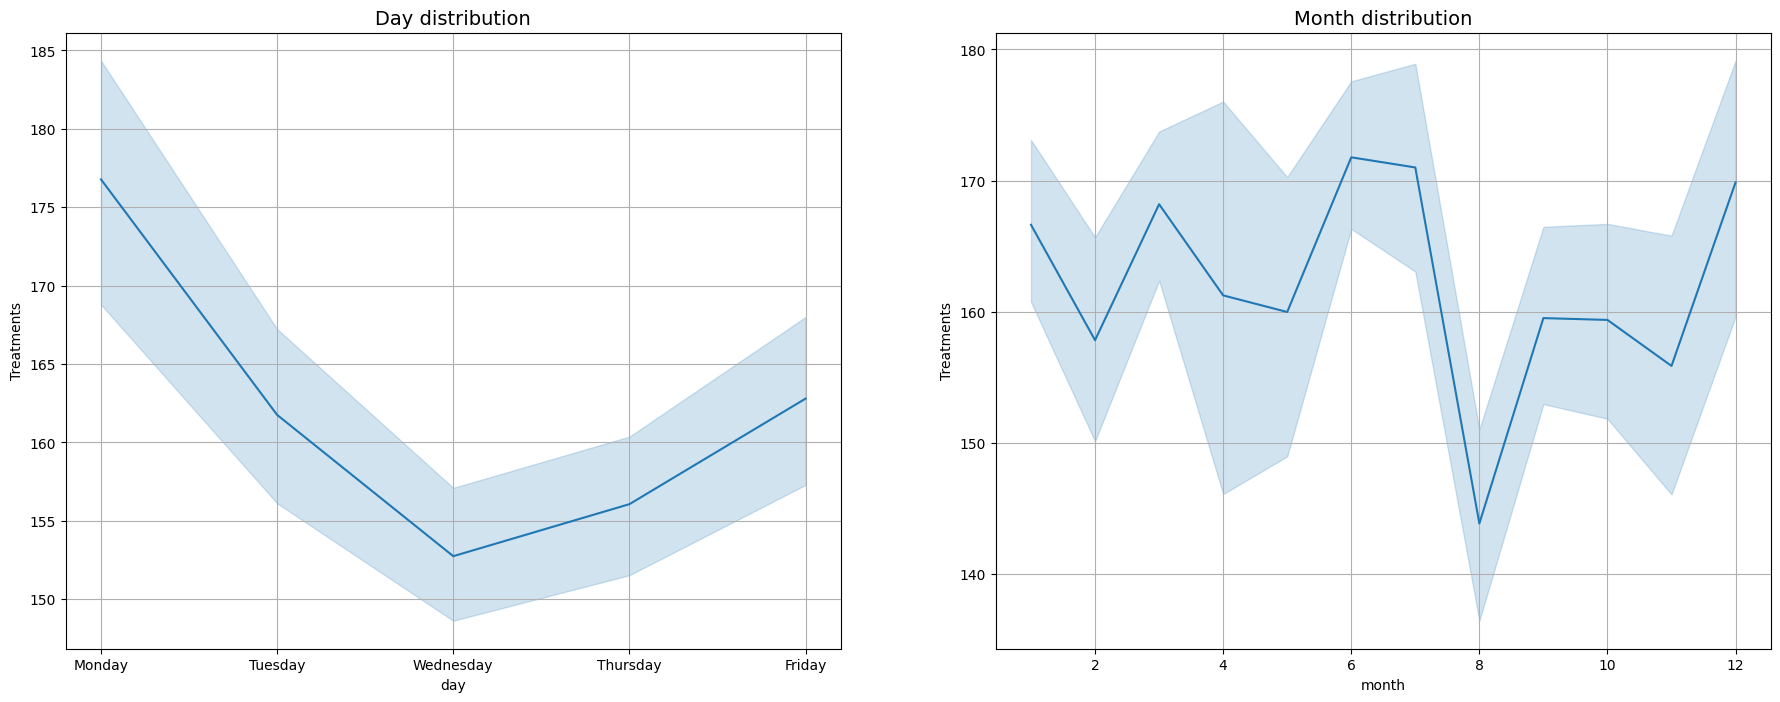

In [33]:
# Plot Distribution by month and day

# Create a new variable
ts1 = ts.copy()

# Create day and month columns
ts1['day'] = ts1.index.day_name()
ts1['month'] = ts1.index.month

# cutoff date to exclude 2024 because the year of 2024 is incomplet
cutoff_date = pd.to_datetime('2024-01-01')

# New dataframe without 2024
ts2 = ts1[ts1.index < cutoff_date]

# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))
# Create a line plot
sns.lineplot(data= ts2, x='day', y='Treatments',ax=ax[0])
ax[0].set_title('Day distribution', fontsize='14')
ax[0].grid(True)

sns.lineplot(data= ts2, x='month', y='Treatments',ax=ax[1])
ax[1].set_title('Month distribution', fontsize='14')
ax[1].grid(True)

# Display the plots
plt.show()


### Seasonality by Day and Month

We can confirm that our assumptions appear to be correct.

The seasonality exists among the days of the week. Wednesday being the day with less treatments and Monday the bussiest.

The trend of the treatment along the year becomes clearer with a wave patterns emerging. August presents a shape decline of treatments that ramps up until January

In [34]:
# Determine the number of rows containing outliers 

# Compute the 25th percentile value
percentile25 = ts['Treatments'].quantile(0.25)

# Compute the 75th percentile value
percentile75 = ts['Treatments'].quantile(0.75)

# Compute the interquartile range
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers
outliers = ts[(ts['Treatments'] > upper_limit) | (ts['Treatments'] < lower_limit)]

# Count how many rows in the data contain outliers
print("Number of rows in the data containing outliers in `Treatments`:", len(outliers))

# Display the outliers
outliers 

Lower limit: 91.5
Upper limit: 231.5
Number of rows in the data containing outliers in `Treatments`: 22


,Treatments
Date,
2022-04-15,60.0
2022-04-18,22.0
2022-09-30,232.0
2022-12-05,234.0
2022-12-26,63.0
2023-04-07,57.0
2023-04-10,24.0
2023-04-11,272.0
2023-05-01,28.0


### Outliers handling

The outliers of this dataset appear to be legitamate values.
They are not errors inputted in the system. They appear to be more extreme flutuations in the number of treatments.

We want to capture these flutuations in our model so the outliers will be included in the next steps of the analysis.

## Data Modelling

As previously said we will compare three diferent models:

- Exponential smoothing [more info](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
- Sarimax [more info](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
- XG Boosting for time series regression [more info](https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/)

The first two are statistical models while XG Boosting is a machine learning model.

Each model will follow these stages

### Spliting the data

The data will be splitted in two parts.

- Training data: for the model to understand the patterns present
- Test data: where we will confront the prediction of the model with the actuals values of our test data

### Hyperparameters and cross-validation 

Which model contaings their specifications for diferent parameters that they can accept.

Grid search will be employed in order to test all possible combinations and find the best predictions.

To minimize the risk of overfitting our data, meaning that we will explain the training data very well but the prediction will not generalize well, the time series validator will be used.
The validator will use the technic of cross-validation.

This is how the cross-validation for time series works: in simple terms the data is divided into folds and each fold is ordered cronologically.

Example: if we specify 5 folds, the training data will create 5 steps for validation.

This process ensures that the data does not overfits and will generalize well.

### Evaluation metrics

The evaluation metrics used for comparing model performance are the following:

- Mean Absolute Error (MAE) [more info](https://en.wikipedia.org/wiki/Mean_absolute_error)
- Mean Squarred Error (MSE) [more info](https://en.wikipedia.org/wiki/Mean_squared_error)
- Root Mean squarred Error (RMSE) [more info](https://en.wikipedia.org/wiki/Root_mean_square_deviation)

RMSE will be used as the main metric of evaluation while the others will be a complementary indicators of performance.

In [35]:
# Splitting the data into train and test variables

# Determine the index to split the data into train and test sets
split_index = int(len(ts) * 0.8)

# Split the data into train and test sets
train = ts.iloc[:split_index]
test = ts.iloc[split_index:]

In [36]:
# Hyperparameters tunning for exponential smoothing

def exponential_smoothing_grid_search(data, param_grid, n_splits=5):
    
    ''' 
    This function determines the best parameters for the exponential smoothing model.
    The model accepts 3 parameters trend, seasonal and seasonal periods.
    Cross validation will be applied in 5 folds
    The for loop will search each parameter and return a dataframe with the information of the evaluation metrics for each best seasonal period.
    '''
    
    # Time series cross-validator
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # List to collect the results
    results_list = []

    # Grid search
    for trend in param_grid['trend']:
        for seasonal in param_grid['seasonal']:
            for seasonal_periods in param_grid['seasonal_periods']:
                mae_scores = []
                mse_scores = []
                rmse_scores = []
                # cross-validation
                for train_index, test_index in tscv.split(data):
                    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

                    # Fit model
                    model = ExponentialSmoothing(train_data['Treatments'],
                                                 trend=trend,
                                                 seasonal=seasonal,
                                                 seasonal_periods=seasonal_periods
                                                 ).fit()
                    
                    predictions = model.forecast(len(test_data))

                    # Calculate metrics
                    mae = mean_absolute_error(test_data['Treatments'], predictions)
                    mse = mean_squared_error(test_data['Treatments'], predictions)
                    rmse = np.sqrt(mse)

                    # Append scores
                    mae_scores.append(mae)
                    mse_scores.append(mse)
                    rmse_scores.append(rmse)

                # Average metrics across folds
                avg_mae = sum(mae_scores) / len(mae_scores)
                avg_mse = sum(mse_scores) / len(mse_scores)
                avg_rmse = sum(rmse_scores) / len(rmse_scores)

                # Store results in a list
                results_list.append({
                    'Trend': trend,
                    'Seasonal': seasonal,
                    'Seasonal_Periods': seasonal_periods,
                    'MAE': avg_mae,
                    'MSE': avg_mse,
                    'RMSE': avg_rmse
                })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results_list)

    # Sort the DataFrame by 'Seasonal_Periods' and 'RMSE'
    results_df = results_df.sort_values(by=['Seasonal_Periods', 'RMSE'])

    # Filter the best result for each seasonal period
    smoothing_results = results_df.groupby('Seasonal_Periods').first().sort_values('RMSE').reset_index()
    smoothing_results['Model'] = 'Exponential smoothing'

    return smoothing_results

# Parameters to search
param_grid = {
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [3, 5, 7, 9, 14]
}

# Fit the train data to our model
smoothing_results = exponential_smoothing_grid_search(train, param_grid)

# Display results
smoothing_results.head()

c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\h

,Seasonal_Periods,Trend,Seasonal,MAE,MSE,RMSE,Model
0,3,mul,add,25.498562,1166.163153,32.776729,Exponential smoothing
1,5,add,add,29.218711,1442.067917,36.255575,Exponential smoothing
2,14,add,add,29.045151,1431.531884,36.264258,Exponential smoothing
3,9,add,add,29.332417,1439.544742,36.601898,Exponential smoothing
4,7,add,add,30.033483,1519.427891,37.347886,Exponential smoothing


The seasonal periods with the lowest RMSE is 3.

This is strange since previously we noticed that the seasonality varies along the week.

Let's plot the results of the models against the test data to see how the forecast behaves.

<Figure size 1200x600 with 0 Axes>

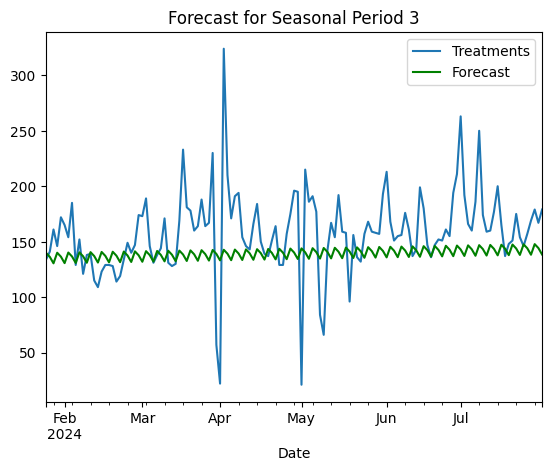

<Figure size 1200x600 with 0 Axes>

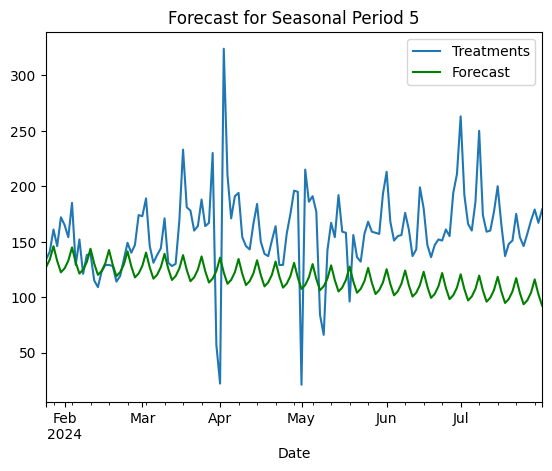

<Figure size 1200x600 with 0 Axes>

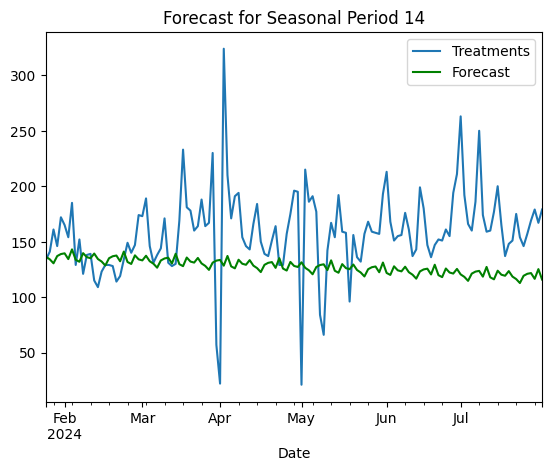

<Figure size 1200x600 with 0 Axes>

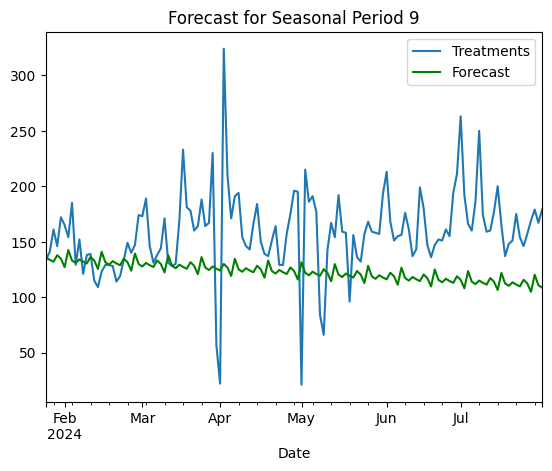

<Figure size 1200x600 with 0 Axes>

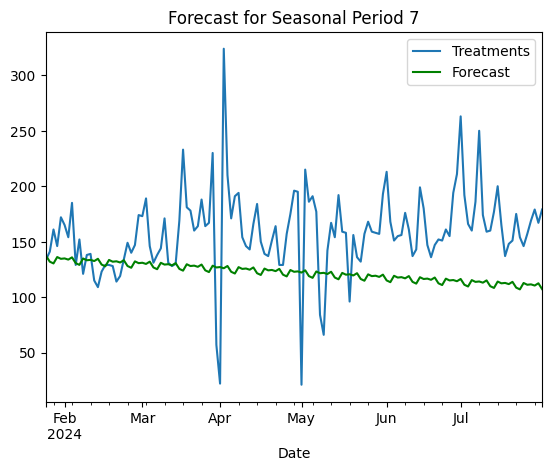

In [37]:
# Plotting forecasts for each best model
for index, row in smoothing_results.iterrows():
    trend = row['Trend']
    seasonal = row['Seasonal']
    seasonal_periods = row['Seasonal_Periods']
    
    # Fit the model with the best parameters
    model = ExponentialSmoothing(train['Treatments'],
                                 trend=trend,
                                 seasonal=seasonal,
                                 seasonal_periods=seasonal_periods
                                 ).fit()

    # Forecast the same number of periods as the test data
    forecast = model.forecast(len(test))

    # Align the index of the forecast with the test data
    forecast.index = test.index

    # Plot the actual vs forecasted values
    plt.figure(figsize=(12, 6))
    test.plot(label='Test')
    forecast.plot(label='Forecast', color='green')
    plt.title(f'Forecast for Seasonal Period {seasonal_periods}')
    plt.legend()
    plt.show()

Analysing the plots we can notice that the model is not adjusting it's trend.

Also the variance of the seasonal period 5 captures better fluctuations of the data but since the error is great it does not receive the best score.

So we can conclude that the results for this model are poor.


In [42]:
# Hyperparameter tunning for sarimax

# Atention this cell can take about 1 hour to run. you can find the results in the next cell

def sarima_grid_search(data, s_param_grid, k_split=5):
    ''' 
    This function determines the best parameters for the sarimax model.
    The model accepts 7 parameters.
    Cross validation will be applied in 5 folds
    The for loop will search each parameter and return a dataframe with the information of the evaluation metrics for each best seasonal period (s_values).
    '''
    results = []
    tscv = TimeSeriesSplit(n_splits=k_split)

    for p in s_param_grid['p_values']:
        for d in s_param_grid['d_values']:
            for q in s_param_grid['q_values']:
                for P in s_param_grid['P_values']:
                    for D in s_param_grid['D_values']:
                        for Q in s_param_grid['Q_values']:
                            for s in s_param_grid['s_values']:
                                cfg = (p, d, q, P, D, Q, s)
                                mae_scores = []
                                mse_scores = []
                                rmse_scores = []

                                for train_index, test_index in tscv.split(data):
                                    train, test = data.iloc[train_index], data.iloc[test_index]
                                    try:
                                        # Attempt to fit SARIMAX model
                                        model = SARIMAX(train, order=(p, d, q), 
                                                        seasonal_order=(P, D, Q, s), 
                                                        enforce_stationarity=False, 
                                                        enforce_invertibility=False)
                                        model_fit = model.fit(disp=False)
                                        predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

                                        mae = mean_absolute_error(test, predictions)
                                        mse = mean_squared_error(test, predictions)
                                        rmse = np.sqrt(mse)

                                        mae_scores.append(mae)
                                        mse_scores.append(mse)
                                        rmse_scores.append(rmse)
                                    except Exception as e:
                                        print(f"Error with configuration {cfg}: {e}")
                                        continue

                                # Calculate mean metrics for the current configuration
                                mean_mae = np.mean(mae_scores)
                                mean_mse = np.mean(mse_scores)
                                mean_rmse = np.mean(rmse_scores)

                                # Store the results
                                results.append({
                                    'p_values': p,
                                    'd_values': d,
                                    'q_values': q,
                                    'P_values': P,
                                    'D_values': D,
                                    'Q_values': Q,
                                    's_values': s,
                                    'MAE': mean_mae,
                                    'MSE': mean_mse,
                                    'RMSE': mean_rmse
                                })

    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort the DataFrame by 's_values' and 'RMSE'
    results_df = results_df.sort_values(by=['s_values', 'RMSE'])

    # Filter the best result for each seasonal period
    sarimax_results = results_df.groupby('s_values').first().sort_values('RMSE').reset_index()
    sarimax_results['Model'] = 'SARIMAX'

    return sarimax_results

# Parameters to search
s_param_grid = {
    'p_values': [0, 1, 2],
    'd_values': [0, 1],
    'q_values': [0, 1, 2],
    'P_values': [0, 1],
    'D_values': [0, 1],
    'Q_values': [0, 1, 2],
    's_values': [3, 5, 7]
}

# Fit train data to our function
sarimax_results = sarima_grid_search(train, s_param_grid)

# Save the DataFrame to a file
with open('sarimax_results.pkl', 'wb') as file:
    pickle.dump(sarimax_results, file)

c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

The results for the code above can take a while to run because we have 648 possible parameters combinations. 

The wait time can be close to 1 hour.
That is why we save the results in a pickle file.

Concerning the results this time the seasonal period make more sense since 5, a week, is the seasonal period with the best RMSE.

Let's plot the result to see if the forecast fits better the test data

In [43]:
# Load the DataFrame from the file
with open('sarimax_results.pkl', 'rb') as file:
    sarimax_results = pickle.load(file)
    
sarimax_results.head()

,s_values,p_values,d_values,q_values,P_values,D_values,Q_values,MAE,MSE,RMSE,Model
0,5,2,0,2,0,1,1,21.131146,847.697908,28.654489,SARIMAX
1,3,0,0,1,1,1,2,22.805265,921.753059,29.997200,SARIMAX
2,7,1,1,1,0,0,0,23.332002,984.121342,30.485384,SARIMAX


c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


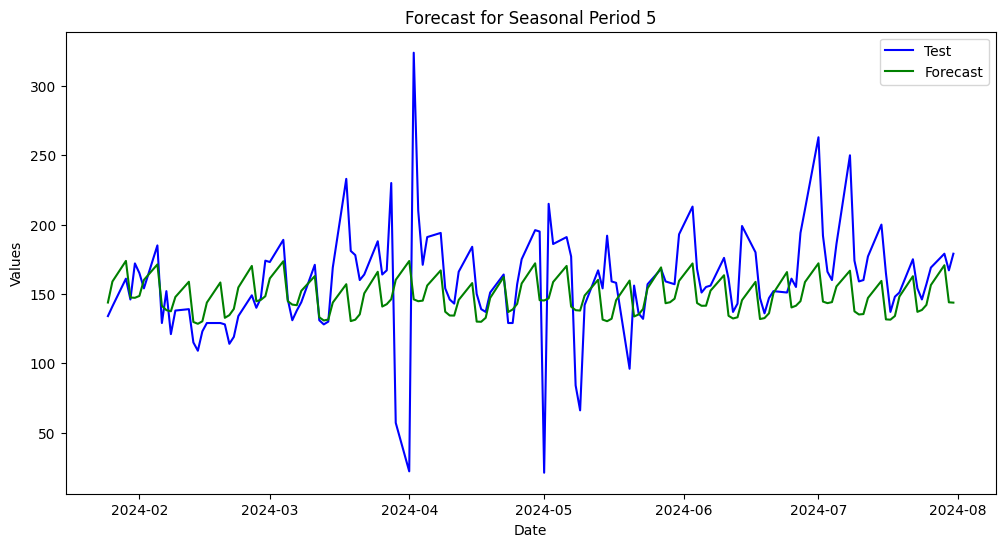

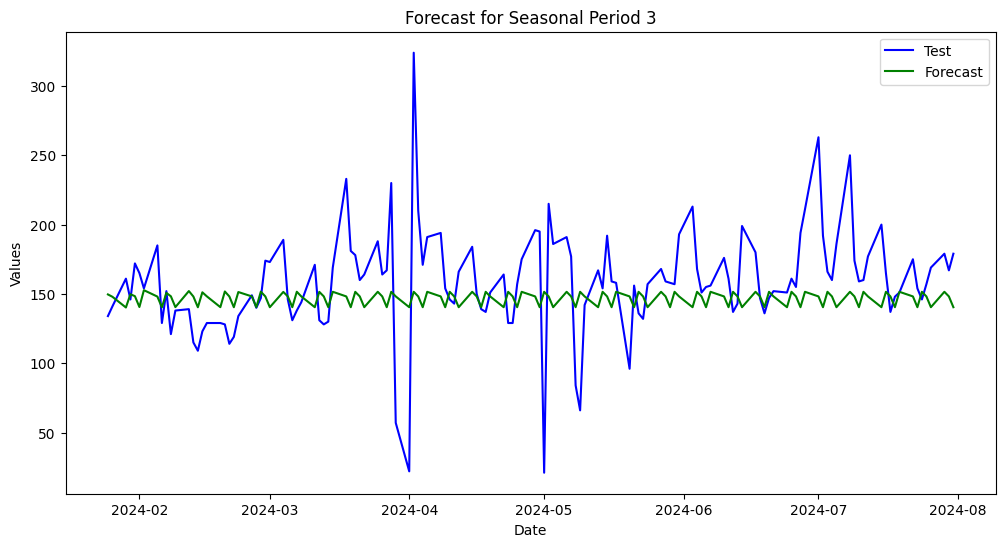

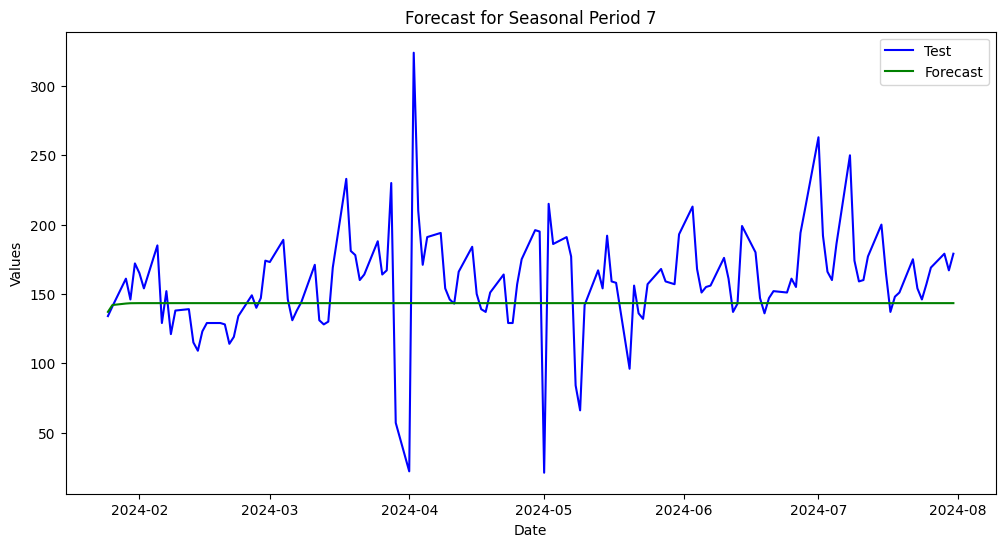

In [44]:
# Plotting forecasts for each best model
for index, row in sarimax_results.iterrows():
    s = row['s_values']
    p = row['p_values']
    d = row['d_values']
    q = row['q_values']
    P = row['P_values']
    D = row['D_values']
    Q = row['Q_values']
    
    model = SARIMAX(train, order=(p, d, q), 
                    seasonal_order=(P, D, Q, s), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False
                    )
    
    model_fit = model.fit(disp=False)
    
   # Forecast the same number of periods as the test data
    forecast_steps = len(test)
    predictions = model_fit.get_forecast(steps=forecast_steps).predicted_mean

    # Plot the actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Test', color='blue')
    plt.plot(test.index, predictions, label='Forecast', color='green')
    plt.title(f'Forecast for Seasonal Period {s}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

We can determine that the seasonal period of 5 is the best predictor of the test data.

Although the result appear to capture the trend and the seasonality quite well can XG Boosting do a better job at that?

### XG Boosting and feature engineering

XGBoosting for time series prediction is a powerful machine learning approach that applies the XGBoost algorithm to forecast future values based on historical data. Unlike traditional time series models, XGBoost doesn't require the data to be stationary or follow any specific pattern. It treats the time series problem as a supervised learning task by creating features from past observations (like lags and rolling statistics) and then predicts future values using these features.

Feature engineering is the process of transforming raw data into meaningful features that better represent the underlying problem to predictive models, improving their performance. It involves creating new features, selecting relevant ones, and modifying existing features to enhance the model's ability to learn patterns.

We will create new feature to our ts dataframe in order to improve the predictive power of our model.

In [45]:

# feature creation

def date_features(data):
    """
    Create time series features based on the index of the dataframe
    Args:
        data (_dataframe_): dataframe with time series
    """
    
    data = data.copy()
    data['day_of_week'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['day_of_year'] = data.index.dayofyear
    data['day_of_month'] = data.index.day
    data['week_of_year'] = data.index.isocalendar().week
    
    return data

def add_lags(data):
    """
    Add lag features based on the index of the dataframe 

    Args:
        data (_dataframe_): dataframe with time series
    """
    target_map = data['Treatments'].to_dict()
    
    data['lag_day'] = data.index - pd.offsets.BDay(1)
    data['lag_day'] = data['lag_day'].map(target_map)
    
    data['lag_week'] = data.index - pd.offsets.BDay(5)
    data['lag_week'] = data['lag_week'].map(target_map)
    
    data['lag_month'] = data.index - pd.offsets.BDay(20)
    data['lag_month'] = data['lag_month'].map(target_map)
    
    data['lag_year'] = data.index - pd.offsets.BDay(240)
    data['lag_year'] = data['lag_year'].map(target_map)
    
    return data

def apply_fourier_transform(data):
    """
    Adds fourier_transform column to the dataframe.
    fourier is used to capture the seasonality of data
    Args:
        data (_dataframe_): dataframe with time series
    """
    values = data['Treatments'].values
    fourier_transform = fft(values)
    data['fourier'] = np.abs(fourier_transform)
    
    return data

def rolling_means(data):
    """
    Adds rolling means to the dataframe

    Args:
        data (_dataframe_): dataframe with time series
    """
    data['avg_rolling_month'] = data['Treatments'].rolling(window='20D').mean()
    data['avg_rolling_2_months'] = data['Treatments'].rolling(window='40D').mean()
    data['avg_rolling_3_months'] = data['Treatments'].rolling(window='60D').mean()
    data['avg_rolling_6_months'] = data['Treatments'].rolling(window='120D').mean()
    data['avg_rolling_12_months'] = data['Treatments'].rolling(window='240D').mean()
    
    return data

# Apply the function to the dataframe
ts = ts.pipe(date_features).pipe(add_lags).pipe(apply_fourier_transform).pipe(rolling_means)

# Check the new variables
ts.head()

,Treatments,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,lag_day,lag_week,lag_month,lag_year,fourier,avg_rolling_month,avg_rolling_2_months,avg_rolling_3_months,avg_rolling_6_months,avg_rolling_12_months
Date,,,,,,,,,,,,,,,,,,
2022-01-03,157.0,0,1,1,2022,3,3,1,NaN,NaN,NaN,NaN,108183.000000,157.000000,157.000000,157.000000,157.000000,157.000000
2022-01-04,148.0,1,1,1,2022,4,4,1,157.0,NaN,NaN,NaN,4267.132020,152.500000,152.500000,152.500000,152.500000,152.500000
2022-01-05,158.0,2,1,1,2022,5,5,1,148.0,NaN,NaN,NaN,1365.318110,154.333333,154.333333,154.333333,154.333333,154.333333
2022-01-06,151.0,3,1,1,2022,6,6,1,158.0,NaN,NaN,NaN,614.126256,153.500000,153.500000,153.500000,153.500000,153.500000
2022-01-07,153.0,4,1,1,2022,7,7,1,151.0,NaN,NaN,NaN,1949.322305,153.400000,153.400000,153.400000,153.400000,153.400000


In [46]:
# Determine the index to split the data into train and test sets
split_index = int(len(ts) * 0.8)

# Split the data into training and test sets
train = ts.iloc[:split_index]
test = ts.iloc[split_index:]

# Features to help the model
features = ['day_of_week',
            'quarter',
            'month',
            'year',
            'day_of_year',
            'day_of_month',
            'week_of_year',
            'lag_day',
            'lag_week',
            'lag_month',
            'lag_year',
            'fourier',
            'avg_rolling_month',
            'avg_rolling_2_months',
            'avg_rolling_3_months',
            'avg_rolling_6_months',
            'avg_rolling_12_months'
            ]

# Target variable for the model to predict
target = 'Treatments'

# Split the train and test for features and target variables
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [47]:
# hyperparameters tunning

# Call the XG Boosting regressor
reg = xgb.XGBRegressor(objective='reg:linear', random_state = 0)

# Hyperparameters grid
cv_params = {'max_depth': [2,3,4,5],
             'learning_rate': [0.01, 0.02, 0.03, 0.04],
             'subsample': [0.5, 0.6, 0.7, 0.8],
             'n_estimators': [400, 450, 500, 550, 600]
             }

# Scoring metrics of the model

# Custom RMSE scorer
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorings = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
            'MSE': make_scorer(mean_squared_error, greater_is_better=False),
            'RMSE': make_scorer(rmse_scorer, greater_is_better=False)
           }

# Grid search
xgb_cv = GridSearchCV(reg,
                      cv_params,
                      scoring= scorings,
                      cv=5,
                      refit='RMSE')

# fit the GridSearchCV to the training data
xgb_cv.fit(X_train, y_train)

c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objectiv

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                         'n_estimators': [400, 450, 500, 550, 600],
                         'subsample': [0.5, 0.6, 0.7, 0.8]},
             refit='RMSE',
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                      'RMSE': make_scorer(rmse_scorer, greater_is_better=False, response_method='predict')})

{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.8}


c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


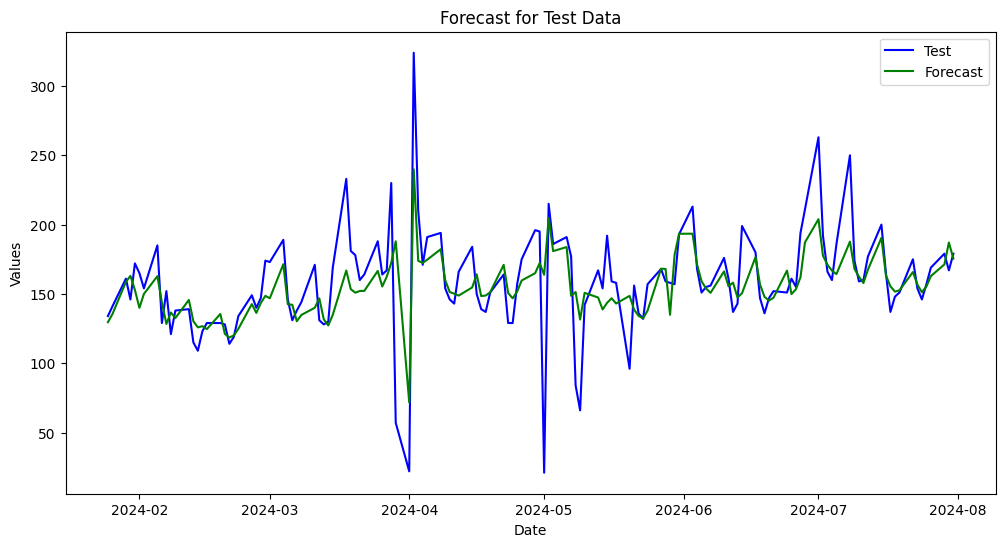

In [48]:
# Get the best parameters from the grid search
best_params = xgb_cv.best_params_
print(best_params)

# train the model with the best parameters
model = xgb.XGBRegressor(objective='reg:linear', **best_params, random_state=0)
model.fit(X_train, y_train)

# Forecast the same number of periods as the test data
predictions = model.predict(X_test)

# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Test', color='blue')
plt.plot(test.index, predictions, label='Forecast', color='green')
plt.title('Forecast for Test Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

We can see how well XG Boosting performs when feature engineering provides features that are relevant for the analysis.

In order to understand which feature contributes to the model we can plot their importance.

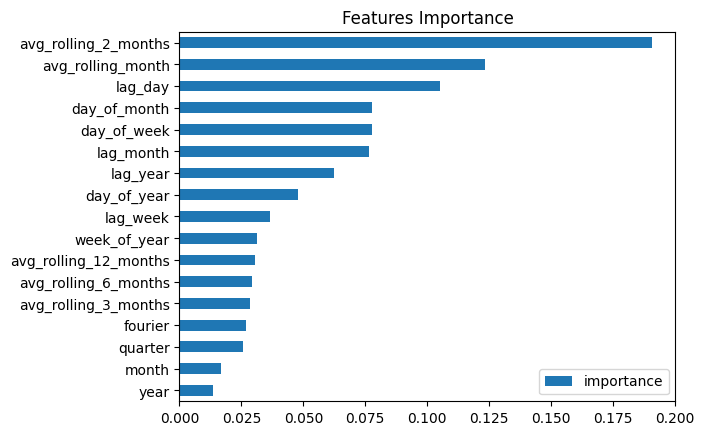

In [49]:
# Feature of importance
feature_importance = pd.DataFrame(data= model.feature_importances_,
                                  index= model.feature_names_in_,
                                  columns=['importance'])

# Plot figure of importance
feature_importance.sort_values('importance').plot(kind='barh', title='Features Importance')
plt.show()

In [50]:
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): MAE, MSE, or RMSE
  
    Returns a pandas DataFrame with the MAE, MSE, and RMSE scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'MAE': 'mean_test_MAE',
        'MSE': 'mean_test_MSE',
        'RMSE': 'mean_test_RMSE'
    }

    # Get all the results from the CV and put them in a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the DataFrame with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract the scores and convert them to positive values
    mae = -best_estimator_results['mean_test_MAE']
    mse = -best_estimator_results['mean_test_MSE']
    rmse = -best_estimator_results['mean_test_RMSE']

    # Create table of results
    table = pd.DataFrame({
        'Model': [model_name],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse]
    })

    return table

In [51]:
# create the dataframe with the evalauation metrics
xgb_cv_results = make_results('XG_Boosting', xgb_cv, 'RMSE')
xgb_cv_results

,Model,MAE,MSE,RMSE
0,XG_Boosting,15.324856,593.103966,23.596686


In [53]:
# Display a dataframe with all the evaluation metrics for each best model
final_results = pd.concat([smoothing_results,sarimax_results,xgb_cv_results]).sort_values('RMSE')
final_results = final_results[['Model','RMSE','MAE','MSE']].reset_index(drop=True)
final_results

,Model,RMSE,MAE,MSE
0,XG_Boosting,23.596686,15.324856,593.103966
1,SARIMAX,28.654489,21.131146,847.697908
2,SARIMAX,29.997200,22.805265,921.753059
3,SARIMAX,30.485384,23.332002,984.121342
4,Exponential smoothing,32.776729,25.498562,1166.163153
5,Exponential smoothing,36.255575,29.218711,1442.067917
6,Exponential smoothing,36.264258,29.045151,1431.531884
7,Exponential smoothing,36.601898,29.332417,1439.544742
8,Exponential smoothing,37.347886,30.033483,1519.427891


## Conclusion and Next steps

We can check in this example that XG Boosting had the best performance of the three models.

For this model feature engineering is essential to produce good results. Always check if your features have an importance for the model, if not, remove them, or create new ones.

In the next part of this project I will implement the final model in Power BI in order for business users to have an easy way to check the predictions of our model.
